# CS 4496/7496 Character Animation (Spring 2020)
Copyright (c) Georgia Institute of Technology

---


# Project 2: Integrators (due 2/17/2020, 11:55PM)

![The Leaning Tower of Pisa, Wikipedia](https://upload.wikimedia.org/wikipedia/commons/thumb/6/66/The_Leaning_Tower_of_Pisa_SB.jpeg/340px-The_Leaning_Tower_of_Pisa_SB.jpeg)

You are standing at the top of the Leaning Tower of Pisa. Just like Galileo, you are trying to convince people that your numerical integrator is accurate by dropping two balls with equal mass from the tower. One ball follows the analytical equation of free-fall motion while the other one is simulated by your particle system. Your goal is to show that they reach the ground at the same time.

In your program, you will implement an analytical solution and two numerical integration methods: Explicit Euler and Midpoint. Show that one of them yields the same motion as the analytical solution, while the other one does not.

In your results, show three objects side-by-side falling from the same height at the same time with zero initial velocity. Render the object that follows the analytical solution as a red sphere, the object that follows Euler method as a green sphere, and the object following Midpoint method as a blue spehere.

Skeleton code for visualization has already been provided.

PyBullet documentation: https://docs.google.com/document/d/10sXEhzFRSnvFcl3XxNGhnD4N2SedqwdAvK3dsihxVUA/edit#

Useful functions: getBasePositionAndOrientation, resetBasePositionAndOrientation, getBaseVelocity, resetBaseVelocity. 

In [70]:
# Install pybullet and related requirements
!apt-get install -y xvfb python-opengl ffmpeg
!pip install pybullet
!pip install ffmpeg-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.3).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


# 1. Skeleton code (do not edit)
### 1.1. Import required libraries

In [0]:
import pybullet as p
import pybullet_data as pd
import time
import ffmpeg
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from PIL import Image
import numpy as np

### 1.2. Initialize Camera and PyBullet Parameters

In [0]:
# Initialize Camera
pixelWidth, pixelHeight = 640, 360
viewMatrix = p.computeViewMatrixFromYawPitchRoll(cameraTargetPosition=[0, 0, 5.0], distance=10.0, yaw=0.0, pitch=0.0, roll=0.0, upAxisIndex=2)
projectionMatrix = p.computeProjectionMatrixFOV(fov=60, aspect=pixelWidth / pixelHeight, nearVal=0.01, farVal=100)
# Initialize PyBullet parameters
p.connect(p.DIRECT)
p.setAdditionalSearchPath(pd.getDataPath())
p.resetSimulation()
flags = p.URDF_INITIALIZE_SAT_FEATURES

### 1.3. Load PyBullet objects and initialize required parameters

In [0]:
# Load objects
plane = p.loadURDF('plane.urdf', [0, 0, 0], flags=flags, useFixedBase=True)
initial_height = 10.0
# Red Sphere - Analytical
obj1Shape = p.createVisualShape(shapeType=p.GEOM_MESH, fileName="sphere_smooth.obj", meshScale=[0.25, 0.25, 0.25], rgbaColor=[1, 0, 0, 1])
obj1 = p.createMultiBody(baseMass=1, baseVisualShapeIndex=obj1Shape, basePosition=[0.0, 0.0, initial_height], flags=flags)
# Green sphere - Euler
obj2Shape = p.createVisualShape(shapeType=p.GEOM_MESH, fileName="sphere_smooth.obj", meshScale=[0.25, 0.25, 0.25], rgbaColor=[0, 1, 0, 1])
obj2 = p.createMultiBody(baseMass=1, baseVisualShapeIndex=obj2Shape, basePosition=[1.0, 0.0, initial_height], flags=flags)
# Blue sphere - Midpoint
obj3Shape = p.createVisualShape(shapeType=p.GEOM_MESH, fileName="sphere_smooth.obj", meshScale=[0.25, 0.25, 0.25], rgbaColor=[0, 0, 1, 1])
obj3 = p.createMultiBody(baseMass=1, baseVisualShapeIndex=obj3Shape, basePosition=[-1.0, 0.0, initial_height], flags=flags)

dt = 1. / 20.  # Time step
g = -9.8  # Acceleration due to gravity
targetPos_obj2, targetVel_obj2 = 0., 0.  # Initialize variables used in Euler method
targetPos_obj3, targetVel_obj3 = 0., 0.  # Initialize variables used in Midpoint method

# 2. Galileo's experiment

The first task is to write the code for defining the "system" of each free-falling object. Do you remember which functions are needed? ** **write your code below (10 pts)**  **

In [0]:
class Freefall(object):
  """ A dynamics system of a freefall object.
  """
  def __init__(self, obj, g, initial_state):
    """Initialize the object that is free-falling.

    Args:
      obj: the object in pybullet
      g: the gravity constant
      initial_state: the initial state at the beginning
    """
    # pass
    self.obj = obj
    self.state = initial_state
    self.g = g

  
  def get_dim(self):
    """Returns the dimension of the state."""
    return len(self.state)

  def get_state(self):
    """Returns the current height and velocity."""
    return self.state

  def set_state(self, state):
    """Updates the height and vertical velocity of the object."""
    self.state = state

  def get_derivative(self):
    """Returns the derivative of the given system."""
    return np.array((self.state[1], g))

  
  def update_pybullet(self):
    """Updates the position and velocity of the object for visualization.
    """
    obj = self.obj
    x, y, _ = p.getBasePositionAndOrientation(obj)[0]
    z, dz = self.state
    p.resetBasePositionAndOrientation(obj, posObj=[x, y, z], ornObj=[0, 0, 0, 1])
    p.resetBaseVelocity(obj, linearVelocity=[0, 0, dz]) 


Now it is time to implement all the integrators.

Let's write the analytical solution first. For analytically solving the free-fall motion, we need to know its initial height and gravity constant. ** **write your code below (15 pts)**  **

In [0]:
class AnalyticSolver(object):
  """AnalyticSolver, specific to a free falling object."""
  def __init__(self, initial_height, g):
    """Initializes the solver.

        Args:
          initial_height: initial height of the object.
          g: gravity constant.
    """
    self.initial_height = initial_height
    self.g = g
    
  
  def step(self, system, t, dt):   ## dt is not necessary here, do not need to call state here
    """Returns the system state at the given time."""
    state = np.array([self.initial_height, 0])
    state[0] = state[0] + t * state[1] + g * t * t / 2
    state[1] = state[1] + t * g
    system.set_state(state)
    new = system.get_state()
    return new



Then the next is the Explicit Euler method. ** **write your code below (15 pts)**  **

In [0]:
class ExplicitEulerSolver(object):
  """A general Explicit Euler method solver."""
  def __init__(self):
    """Initilializes the solver."""
  
  def step(self, system, t, dt):   ## t is not necessary
    """Advances the system by dt."""
    temp = system.get_state()
    deriv = system.get_derivative()
    temp = temp + dt * (deriv)
    system.set_state(temp)
    new = system.get_state()
    return new

The third one is the Midpoint method (hint: compute x_mid and f_mid. don't forget to store the original state x0). ** **write your code below (15 pts)**  **

In [0]:
class MidpointSolver(object):
  """A general Midpoint method solver."""
  def __init__(self):
    """Initilializes the solver."""
  
  def step(self, system, t, dt):
    """Advances the system by dt."""
    temp1 = system.get_state()
    mid = temp1 + (dt/2)*system.get_derivative()
    system.set_state(mid)
    new = temp1 + dt*system.get_derivative()
    system.set_state(new)
    final = system.get_state()
    return final


Complete the while-loop below. Also print out the heights of the objects at various points of time to illustrate the difference in solutions obtained using the various methods. The printed messages should be concise but informative. ** **write your code below (15 pts)**  **

In [78]:

def get_heights(systems):
  """A helper function that returns the heights of all systems."""
  return [s.get_state()[0] for s in systems]

i, t = 0, 0.  # Loop counter, Time
heightsToPlot = [[initial_height], [initial_height], [initial_height]]
time = [t]

# Constructs all the systems
init_state_1 = np.array((initial_height, 0.0))
init_state_2 = np.array((initial_height, 0.0))
init_state_3 = np.array((initial_height, 0.0))
system1 = Freefall(obj1, g, init_state_1)
system2 = Freefall(obj2, g, init_state_2)
system3 = Freefall(obj3, g, init_state_3)
systems = [system1, system2, system3]

# Constructs all the 
analytic_solver = AnalyticSolver(initial_height, g)
explicit_euler_solver = ExplicitEulerSolver()
midpoint_solver = MidpointSolver()

while max(get_heights(systems)) > 0.0:
  time.append(t)
  t += dt
  # (TODO) advance each system with integrators.
  init_state_1 = analytic_solver.step(system1, t, dt)
  init_state_2 = explicit_euler_solver.step(system2, t, dt)
  init_state_3 = midpoint_solver.step(system3, t, dt)

  heights = get_heights(systems)
  heightsToPlot.append(get_heights(systems))

  # (TODO) Print the values for debugging.
  # print(heights)
  # print(heightsToPlot)
  
  # Update the values for plot and visualization
  for j, system_j in enumerate(systems):
    system_j.update_pybullet()
    heightsToPlot[j].append(heights[j])

  # Render images
  _, _, img, _, _ = p.getCameraImage(pixelWidth, pixelHeight, viewMatrix,projectionMatrix, shadow=1, lightDirection=[1,1,1])
  Image.fromarray(img[:, :, :3]).save('./frame%04d.jpg' % i)
  i += 1

print("Done. t = {}".format(t))


Done. t = 1.5000000000000007


#### Let us now visualize the results of our experiments, Make sure that you can see the animation of three free-falling objects.


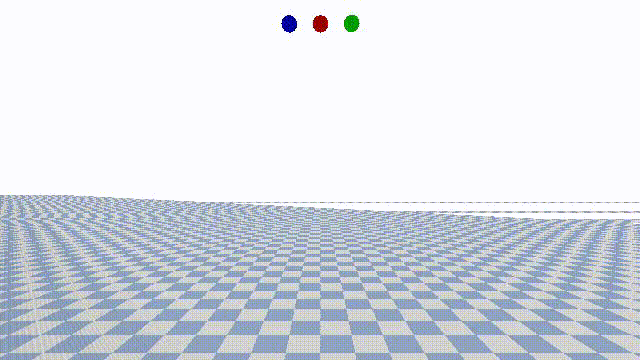

In [79]:
def show_gif_image(filename):
  video = io.open(filename, 'r+b').read()
  encoded = base64.b64encode(video)
  ipythondisplay.display(HTML(data='''<img src="data:image/gif;base64,{0}"/>'''.format(encoded.decode('ascii'))))

# Zip the animation in to gif
ffmpeg.input('./frame*.jpg', pattern_type='glob', framerate=20.0).output('./output.gif').overwrite_output().run()
show_gif_image('./output.gif')

#### Let us also look at the plot of heights vs time:

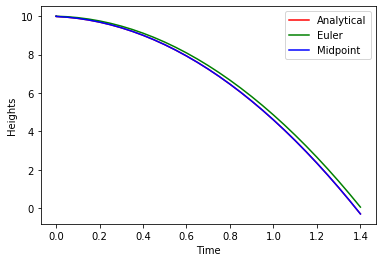

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline

time = time[:-1]
heightsToPlot[0] = heightsToPlot[0][:-1]
heightsToPlot[1] = heightsToPlot[1][:-1]
heightsToPlot[2] = heightsToPlot[2][:-1]
plt.figure()
plt.plot(time, heightsToPlot[0], 'r-', label='Analytical')
plt.plot(time, heightsToPlot[1], 'g-', label='Euler')
plt.plot(time, heightsToPlot[2], 'b-', label='Midpoint')
plt.xlabel('Time')
plt.ylabel('Heights')
plt.legend()
plt.show()

Can you see all three height trajectories over time? Discuss the results, particularly in terms of the accuracy of each method. Will the results be different if we take a smaller/larger time step? ** **write your answer below (20 pts)** **

We first calculate the theoretical time when it drops at the ground can be calculate as 10 = x0 + v0 * t + 1/2 * g * t^2 . Here x0 and v0 are both zero, so theoretical time is around 1.4278 sec. 

Initially, dt is set to be 1/20. When we plot through Analytic, Euler and Midpoint, we can see that the dropping line generated by Midpoint method is generally coincident with Analytic curve, while curve generate by Euler has some difference. Thus, we can conclude that Midpoint method is more accurate than Euler method. In addition, the generate time t is 1.5 sec, which is dominated by the slowest / most inaccurate method, Euler. 

Then we decreases dt to 1/50 and 1/80. When dt = 1/50, the difference between analytic and Euler has significantly decreased, and time t is changed to 1.44 sec. Then we further decrease to 1/80, t is reduced to 1.4375 sec and the different is further minimized as well. 

In adiition, we increase dt to 1/10 and 1/5. As we expect, when dt increases, difference between Euler and Analytic increases as well. However, curve by Midpoint method is always identical to the theoretical one, which proves the accuracy of midpoint method. And the time for dt = 1/10 is 1.5 sec as well, but for dt = 1/5, it changes to 1.599 sec. 

Below are all plots that I generated for these dt:

[image when dt = 1/5](https://drive.google.com/open?id=1gHIzKcA0goMf3_-aUU-3acz05EDVLbEQ)

[image when dt = 1/10](https://drive.google.com/open?id=1Tl7_Ozrl0nVG1sai2tW-t3_uUXsBTcBV)

[image when dt = 1/20](https://drive.google.com/open?id=1Mm8Um1xRC9SIXp3wd-_LabDG51oNjaCD)

[image when dt = 1/50](https://drive.google.com/open?id=1sR3YzdvAlJ9MNwySOtcH9zysA5Ghdc6h)

[image wehn dt = 1/80](https://drive.google.com/open?id=1IxaLimvxVeDvhUOcSECGTvmmZopUCjfX)


# 3. Bead on the wire

Do you remember the bead-on-the-wire example? In this task, we will implement the system of the bead-on-the-wire where a 2-D particle is governed with two springs in X and Y axis, where their stiffness are $1.0$ and $k$, respectively. ** **write your code below (10 pts)**  **


In [0]:
class BeadOnWire(object):
  '''A bead on the wire system integrated using Euler and Midpoint methods
  '''
  def __init__(self, k, initial_state):
    '''Initialize system parameters

    Args:
    k: Spring constant
    initial_state: Initial system state
    '''
    self.state = initial_state
    self.k = k
  
  
  def get_state(self):
    '''Returns [x(t), y(t)], where x = e^(-t) and y = e^(-kt)
    '''
    return self.state

  def set_state(self, state):
    '''Update x(t) and y(t), where x = e^(-t) and y = e^(-kt)
    '''
    self.state = state


  def get_derivative(self):
    '''Derivative of given system [-e^(-t), -ke^(-kt)]
    '''
    return np.array(( - self.state[0], -k * self.state[1]))

We provide the skeleton code for simulation.

RK4 Method (Copy from extra credit)

In [0]:
class RK4Solver(object):
  def __init__(self):
    pass

  def step(self, system, t, dt):    # pass
    temp = system.get_state()
    temp1 = temp.copy()    
    temp2 = temp.copy() 
    temp3 = temp.copy()

    k1 = dt * system.get_derivative()

    temp1 = temp1 + k1/2
    system.set_state(temp1)
    k2 = dt * system.get_derivative()

    temp2 = temp2 + k2/2
    system.set_state(temp2)
    k3 = dt * system.get_derivative()

    temp3 = temp3 + k3
    system.set_state(temp3)
    k4 = dt * system.get_derivative()

    final = temp + k1/6 + k2/3 + k3/3 + k4/6
    system.set_state(final)


Implicit Euler Method (Copy from extra credit)

In [0]:
class ImplicitEulerSolver(object):
  def __init__(self):
    pass
    
  def step(self, system, t, dt):
    # pass
    temp = system.get_state()
    deriv1 = system.get_derivative()
    fprime = np.array([[-1, 0], [0, -k]])  
    deltaf1 = np.array([[dt/(1+dt), 0], [0, dt/(1+k*dt)]])
    deltaf = deltaf1.dot(deriv1)
    new = temp + dt*deriv1+dt*(deltaf.dot(fprime))
    system.set_state(new)



In [0]:
RK4_solver = RK4Solver()
implicit_solver = ImplicitEulerSolver()

# Create a bead-on-wire system with desired parameters
k = 5
initial_state = np.array([1, 1]) # [e^(-0), e^(-k * 0)]
b_Euler = BeadOnWire(k, initial_state)
b_Midpoint = BeadOnWire(k, initial_state)
b_RK4 = BeadOnWire(k, initial_state)
b_implicit = BeadOnWire(k, initial_state)
# Simulation parameters
dt = 1./ 4.
numTimeSteps = 50
# Lists to store histories which we will plot later
histEuler, histMidpoint, histRK4, histImplicit = [initial_state], [initial_state], [initial_state], [initial_state]


# The mainloop for simulation
for t in range(numTimeSteps):
  explicit_euler_solver.step(b_Euler, t, dt)
  histEuler.append(b_Euler.get_state())

  midpoint_solver.step(b_Midpoint, t, dt)
  histMidpoint.append(b_Midpoint.get_state())

  RK4_solver.step(b_RK4, t, dt)
  histRK4.append(b_RK4.get_state())

  implicit_solver.step(b_implicit, t, dt)
  histImplicit.append(b_implicit.get_state())

# histEuler, histMidpoint = np.array(histEuler), np.array(histMidpoint)
histEuler, histMidpoint, histRK4, histImplicit = np.array(histEuler), np.array(histMidpoint), np.array(histRK4), np.array(histImplicit)


... and the code for visualization as well.

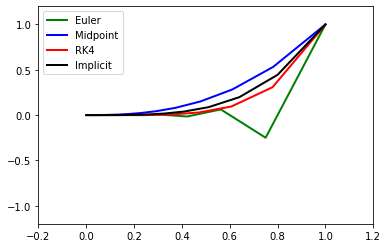

In [85]:
from matplotlib import animation, rc

# Set up initial figure
fig, ax = plt.subplots()
ax.set_xlim(( -0.2, 1.2))
ax.set_ylim((-1.2, 1.2))
colors = ["Green", "Blue", "Red", "Black"]
labels = ["Euler", "Midpoint", "RK4", "Implicit"]

lines = []
for i in range(4):
  lines.append(ax.plot([], [], lw=2, color=colors[i], label=labels[i])[0])

# Initialization function: plot the background of each frame
def init():
  for line in lines:
    line.set_data([], [])
  return lines

# Animation function. This is called sequentially
def animate(i):
  xEuler, yEuler = histEuler[:i + 1, 0], histEuler[:i + 1, 1]
  xMid, yMid = histMidpoint[:i + 1, 0], histMidpoint[:i + 1, 1]
  xRK4, yRK4 = histRK4[:i + 1, 0], histRK4[:i + 1, 1]
  xIm, yIm = histImplicit[:i + 1, 0], histImplicit[:i + 1, 1]
  x = [xEuler, xMid, xRK4, xIm]
  y = [yEuler, yMid, yRK4, yIm]

  for lineNum, line in enumerate(lines):
    line.set_data(x[lineNum], y[lineNum])

  ax.legend()
  return lines

# Call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=numTimeSteps, interval=50, blit=True)
HTML(anim.to_html5_video())

# 4. Extra points
4.1. Implement an additional integrator, RK4, and test it with the bead-on-the-wire example. ** **write your code below (5 pts)**  **

In [0]:
class RK4Solver(object):
  def __init__(self):
    pass

  def step(self, system, t, dt):    # pass
    temp = system.get_state()
    temp1 = temp.copy()    
    temp2 = temp.copy() 
    temp3 = temp.copy()

    k1 = dt * system.get_derivative()

    temp1 = temp1 + k1/2
    system.set_state(temp1)
    k2 = dt * system.get_derivative()

    temp2 = temp2 + k2/2
    system.set_state(temp2)
    k3 = dt * system.get_derivative()

    temp3 = temp3 + k3
    system.set_state(temp3)
    k4 = dt * system.get_derivative()

    final = temp + k1/6 + k2/3 + k3/3 + k4/6
    system.set_state(final)


4.2. Implement an additional integrator, implicit Euler, and verify that you can take a large step on the bead-on-the-wire system. (hint: you may need to implement new member functions to the system.) ** **write your code below (5 pts)**  **

In [0]:
class ImplicitEulerSolver(object):
  def __init__(self):
    pass
    
  def step(self, system, t, dt):
    # pass
    temp = system.get_state()

    deriv1 = system.get_derivative()

    fprime = np.array([[-1, 0], [0, -k]])  
    deltaf1 = np.array([[dt/(1+dt), 0], [0, dt/(1+k*dt)]])
    deltaf = deltaf1.dot(deriv1)
    new = temp + dt*deriv1+dt*(deltaf.dot(fprime))
    system.set_state(new)
